In [2]:
cd ..

/Users/TimSalzmann/Documents/Study/PhD/Code/Motion/experiments-motion


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
MODEL_PATH = './output/amass/deterministic/'

In [5]:
import sys
import os
sys.path.append('./Motion')

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook
import torch
import time
import zarr
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import yaml
from tqdm import tqdm
from IPython.display import display, HTML

In [7]:
from motion import Motion
from motion import Quaternion
from amass.skeleton import AMASSSkeleton
from amass.amass_torch_dataset import AMASSTorchDataset
from misc.helper import add_static_nodes

In [8]:
# Load skeleton configuration
with open('./config/amass_skeleton.yaml', 'r') as stream:
    skeleton = AMASSSkeleton(**yaml.safe_load(stream))

In [9]:
dataset_path = './data/processed/amass'
dataset = 'SSMSynced'

In [10]:
z_index = zarr.open(os.path.join(dataset_path, dataset, 'poses_index.zarr'), 'r')
z_poses = zarr.open(os.path.join(dataset_path, dataset, 'poses.zarr'), 'r')
dataset_eval = AMASSTorchDataset(z_index,
                                z_poses,
                                history_length=40,
                                prediction_horizon=20)

In [11]:
CHECKPOINT = 'model'
CHECKPOINT_PATH = os.path.join(MODEL_PATH, CHECKPOINT + '.pth.tar')

In [12]:
# Load model config
with open(os.path.join(MODEL_PATH, 'config.yaml'), 'r') as file:
    model_config = yaml.safe_load(file)

In [13]:
model = Motion(skeleton, T=skeleton.nodes_type_id_dynamic, **model_config)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))
model.eval()
print('Loaded Model')

Loaded Model


In [32]:
sequence = 390#26 #
with torch.no_grad():
    x, y = dataset_eval[sequence]
    x = x.unsqueeze(0)
    y = y.unsqueeze(0)

    # Remove static nodes
    x_dynamic = Quaternion.qfix_positive_(x[:, :, skeleton.dynamic_nodes])

    # Run Model 
    p_q, _, _, _ = model(x_dynamic, None, ph=20)

    # The mode of the Distribution are the rotations
    q_mode = p_q.mode
    # Add static rotations q = [1., 0., 0., 0.]
    q_mode_all = add_static_nodes(q_mode, skeleton.static_nodes, skeleton.dynamic_nodes)

    pos_mode_all = skeleton(q_mode_all.view(-1, 22, 4)).view(-1, 20, 22, 3)
    pos_y = skeleton(y.view(-1, 22, 4)).view(-1, 20, 22, 3)

<IPython.core.display.Javascript object>


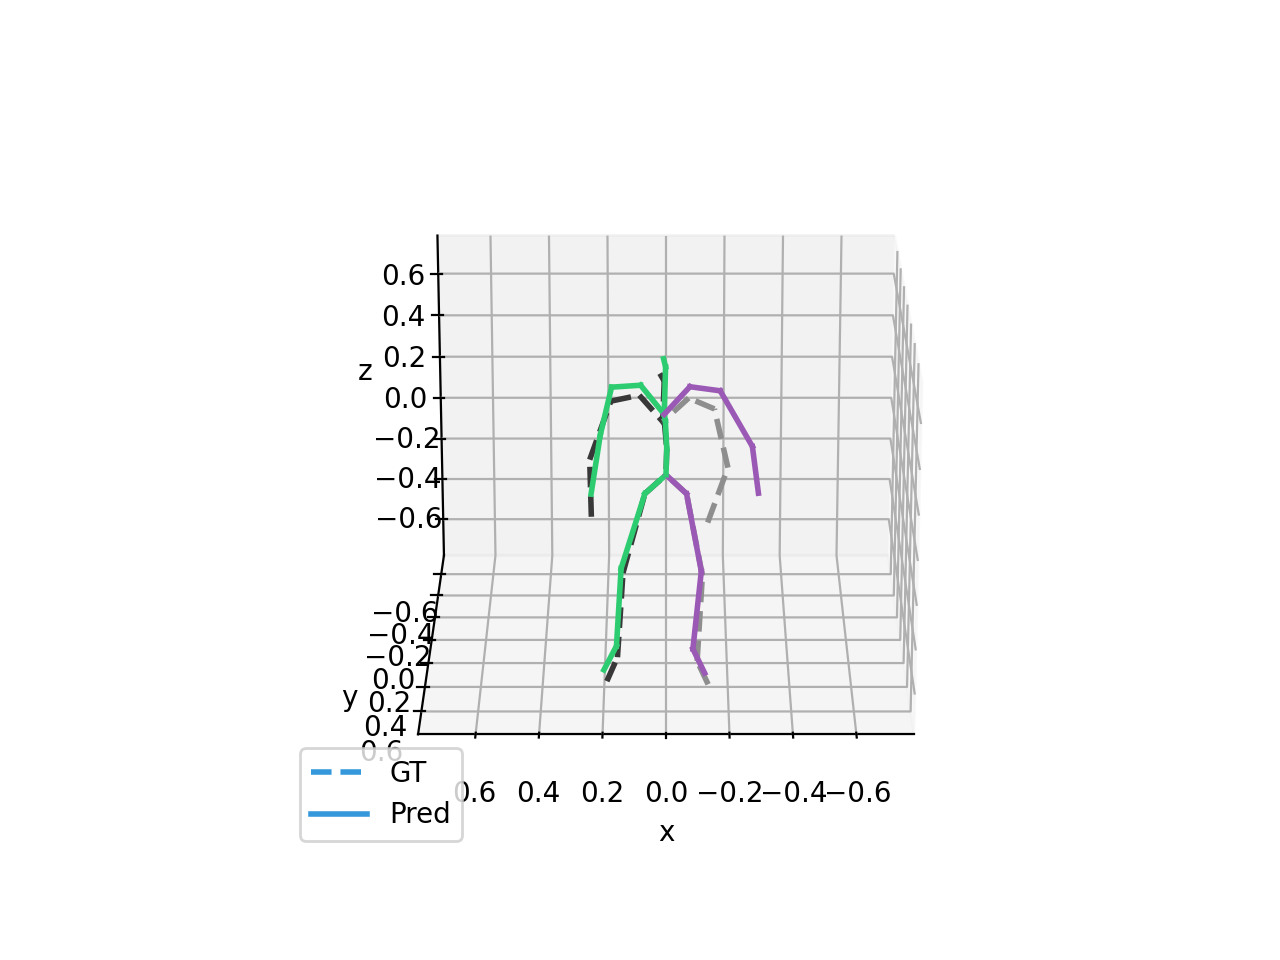

In [33]:
fig = plt.figure()
ax = plt.gca(projection='3d')
ob = Ax3DPose(ax)
for i in range(20):
    ob.update(pos_y[0, i].numpy(), pos_mode_all[0, i].numpy())
    fig.canvas.draw()
    time.sleep(0.15)

In [16]:
class Ax3DPose(object):
    def __init__(self, ax, lcolor="#3498db", rcolor="#e74c3c", label=['GT', 'Pred']):
        """
        Create a 3d pose visualizer that can be updated with new poses.

        Args
          ax: 3d axis to plot the 3d pose on
          lcolor: String. Colour for the left part of the body
          rcolor: String. Colour for the right part of the body
        """

        # Start and endpoints of our representation
        self.I = np.arange(21)+1
        self.J = np.array([0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 12, 13, 14, 16, 17, 18, 19])
        # Left / right indicator
        self.LR = np.array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0], dtype=bool)
        self.ax = ax

        vals = np.zeros((22, 3))

        # Make connection matrix
        self.plots = []
        for i in np.arange(len(self.I)):
            x = np.array([vals[self.I[i], 0], vals[self.J[i], 0]])
            z = np.array([vals[self.I[i], 1], vals[self.J[i], 1]])
            y = np.array([vals[self.I[i], 2], vals[self.J[i], 2]])
            if i == 0:
                self.plots.append(
                    self.ax.plot(x, z, y, lw=2, linestyle='--', c=rcolor if self.LR[i] else lcolor, label=label[0]))
            else:
                self.plots.append(self.ax.plot(x, y, z, lw=2, linestyle='--', c=rcolor if self.LR[i] else lcolor))

        self.plots_pred = []
        for i in np.arange(len(self.I)):
            x = np.array([vals[self.I[i], 0], vals[self.J[i], 0]])
            z = np.array([vals[self.I[i], 1], vals[self.J[i], 1]])
            y = np.array([vals[self.I[i], 2], vals[self.J[i], 2]])
            if i == 0:
                self.plots_pred.append(self.ax.plot(x, y, z, lw=2, c=rcolor if self.LR[i] else lcolor, label=label[1]))
            else:
                self.plots_pred.append(self.ax.plot(x, y, z, lw=2, c=rcolor if self.LR[i] else lcolor))

        self.ax.set_xlabel("x")
        self.ax.set_ylabel("y")
        self.ax.set_zlabel("z")
        # self.ax.set_axis_off()
        # self.ax.axes.get_xaxis().set_visible(False)
        # self.axes.get_yaxis().set_visible(False)
        self.ax.legend(loc='lower left')
        self.ax.view_init(20, 90)

    def update(self, gt_channels, pred_channels):
        """
        Update the plotted 3d pose.

        Args
          channels: 96-dim long np array. The pose to plot.
          lcolor: String. Colour for the left part of the body.
          rcolor: String. Colour for the right part of the body.
        Returns
          Nothing. Simply updates the axis with the new pose.
        """
        conv_cmap =  plt.get_cmap('viridis')
        assert gt_channels.size == 66, "channels should have 96 entries, it has %d instead" % gt_channels.size
        gt_vals = np.reshape(gt_channels, (22, -1))
        lcolor = "#8e8e8e"
        rcolor = "#383838"
        for i in np.arange(len(self.I)):
            x = np.array([gt_vals[self.I[i], 0], gt_vals[self.J[i], 0]])
            z = np.array([gt_vals[self.I[i], 1], gt_vals[self.J[i], 1]])
            y = np.array([gt_vals[self.I[i], 2], gt_vals[self.J[i], 2]])
            self.plots[i][0].set_xdata(x)
            self.plots[i][0].set_ydata(y)
            self.plots[i][0].set_3d_properties(z)
            self.plots[i][0].set_color(lcolor if self.LR[i] else rcolor)
            #self.plots[i][0].set_color(conv_cmap(conf[i]))
            #self.plots[i][0].set_alpha(0.5)

        assert pred_channels.size == 66, "channels should have 96 entries, it has %d instead" % pred_channels.size
        pred_vals = np.reshape(pred_channels, (22, -1))
        lcolor = "#9b59b6"
        rcolor = "#2ecc71"
        for i in np.arange(len(self.I)):
            x = np.array([pred_vals[self.I[i], 0], pred_vals[self.J[i], 0]])
            z = np.array([pred_vals[self.I[i], 1], pred_vals[self.J[i], 1]])
            y = np.array([pred_vals[self.I[i], 2], pred_vals[self.J[i], 2]])
            self.plots_pred[i][0].set_xdata(x)
            self.plots_pred[i][0].set_ydata(y)
            self.plots_pred[i][0].set_3d_properties(z)
            self.plots_pred[i][0].set_color(lcolor if self.LR[i] else rcolor)
            # self.plots_pred[i][0].set_alpha(0.7)

        r = 0.750
        xroot, yroot, zroot = gt_vals[0, 0], gt_vals[0, 1], gt_vals[0, 2]
        self.ax.set_xlim3d([-r + xroot, r + xroot])
        self.ax.set_zlim3d([-r + zroot, r + zroot])
        self.ax.set_ylim3d([-r + yroot, r + yroot])
        self.ax.set_aspect('auto')

In [34]:
import trimesh
from human_body_prior.tools.omni_tools import colors
from human_body_prior.mesh import MeshViewer
from human_body_prior.mesh.sphere import points_to_spheres
from human_body_prior.body_model.body_model import BodyModel
from human_body_prior.tools.omni_tools import copy2cpu as c2c
from human_body_prior.tools.omni_tools import apply_mesh_tranfsormations_
import os
import matplotlib

In [35]:
imw, imh=2000, 3200
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

In [36]:
bm = BodyModel(skeleton._body_model_path)
faces = c2c(bm.f)

In [37]:
def get_img_mesh(q):
    with torch.no_grad():
        pose_body = Quaternion(q.cpu()).axis_angle.flatten(start_dim=1)
        body = bm(pose_body=pose_body)
        body_mesh_wdmpls = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
        mv.set_static_meshes([body_mesh_wdmpls])
        body_image_wdmpls = mv.render(render_wireframe=False)
        return body_image_wdmpls

In [38]:
def get_img_mesh90(q):
    with torch.no_grad():
        pose_body = Quaternion(q.cpu()).axis_angle.flatten(start_dim=1)
        body = bm(pose_body=pose_body)
        body_mesh_wdmpls = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
        apply_mesh_tranfsormations_([body_mesh_wdmpls], trimesh.transformations.rotation_matrix(-80, (1, 0, 0)))
        mv.set_static_meshes([body_mesh_wdmpls])
        body_image_wdmpls = mv.render(render_wireframe=False)
        return body_image_wdmpls

In [39]:
def get_img(i):
    pose_body = Quaternion(q_mode_all[:, i, 1:].cpu()).axis_angle.flatten(start_dim=-2)
    body = bm(pose_body=pose_body)
    body_mesh_wdmpls = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    mv.set_static_meshes([body_mesh_wdmpls])
    body_image_wdmpls = mv.render(render_wireframe=False)
    ax.set_title(str(i))
    return body_image_wdmpls

<IPython.core.display.Javascript object>


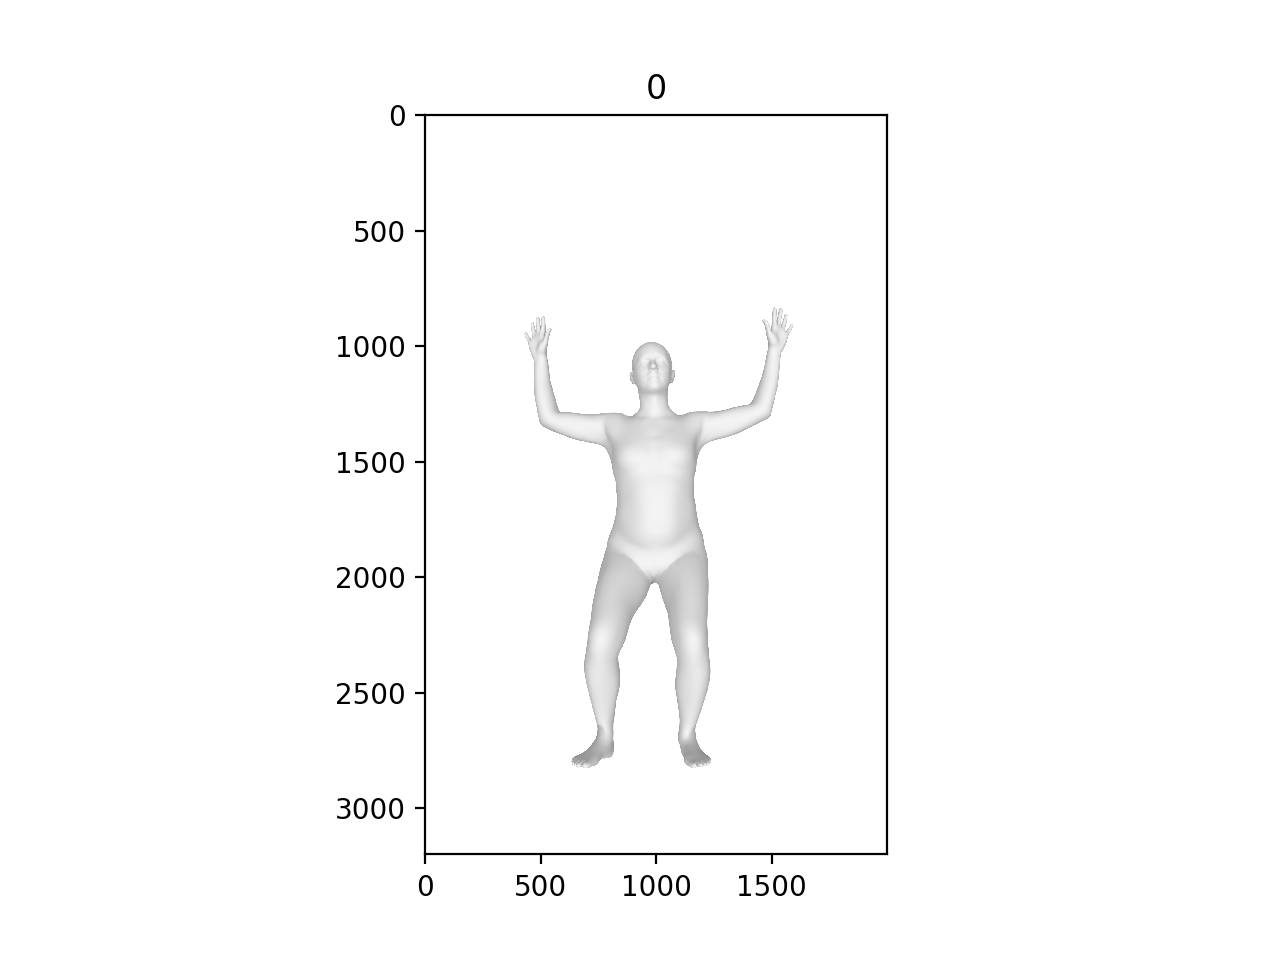

In [28]:
f = plt.figure()
ax = f.gca()

im = get_img(5)
image = plt.imshow(im, interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(get_img(frame_index))
    ax.set_title(str(frame_index))
    return image
   
ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=100, frames=25, blit=True)

In [45]:
probs = p_q.mixture_distribution.probs[0, 0, :, :].mean(dim=-2)

In [46]:
p_q.mixture_distribution.probs[0, 0, :, :]

tensor([[0.3833, 0.0167, 0.2270, 0.3465, 0.0265]])

In [47]:
probs = probs - probs.min()

In [48]:
probs = probs / probs.max()

In [49]:
p_q.component_distribution.mean.shape

torch.Size([1, 20, 22, 5, 4])

<IPython.core.display.Javascript object>


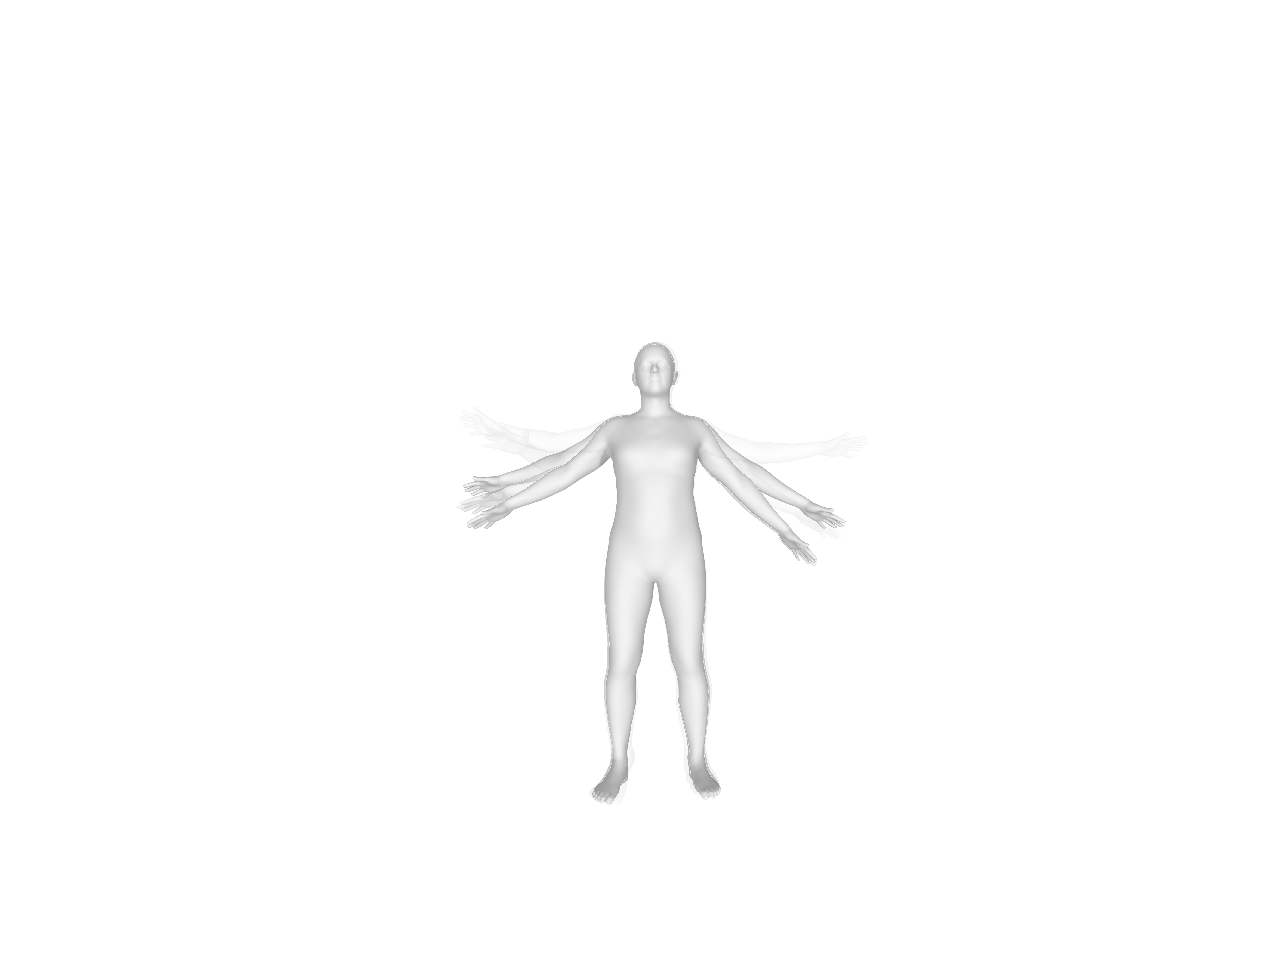

In [65]:
t = 10
f = plt.figure()
plt.axis('off')
ax = f.gca()

for i in range(5):
    im = get_img_mesh(p_q.component_distribution.mean[:, t, 1:, i])
    alpha = np.zeros((3200, 3200, 1)).astype(int)
    alpha[:, :, 0] = (im.mean(axis=-1) != 255).astype(int) * 255
    im = np.concatenate([im, alpha], axis=-1)
    plt.imshow(im, alpha=max(float(probs[i].numpy()), 0.15), interpolation='none')
plt.savefig('./modes_5_front.png', bbox_inches='tight', dpi=500)

<IPython.core.display.Javascript object>


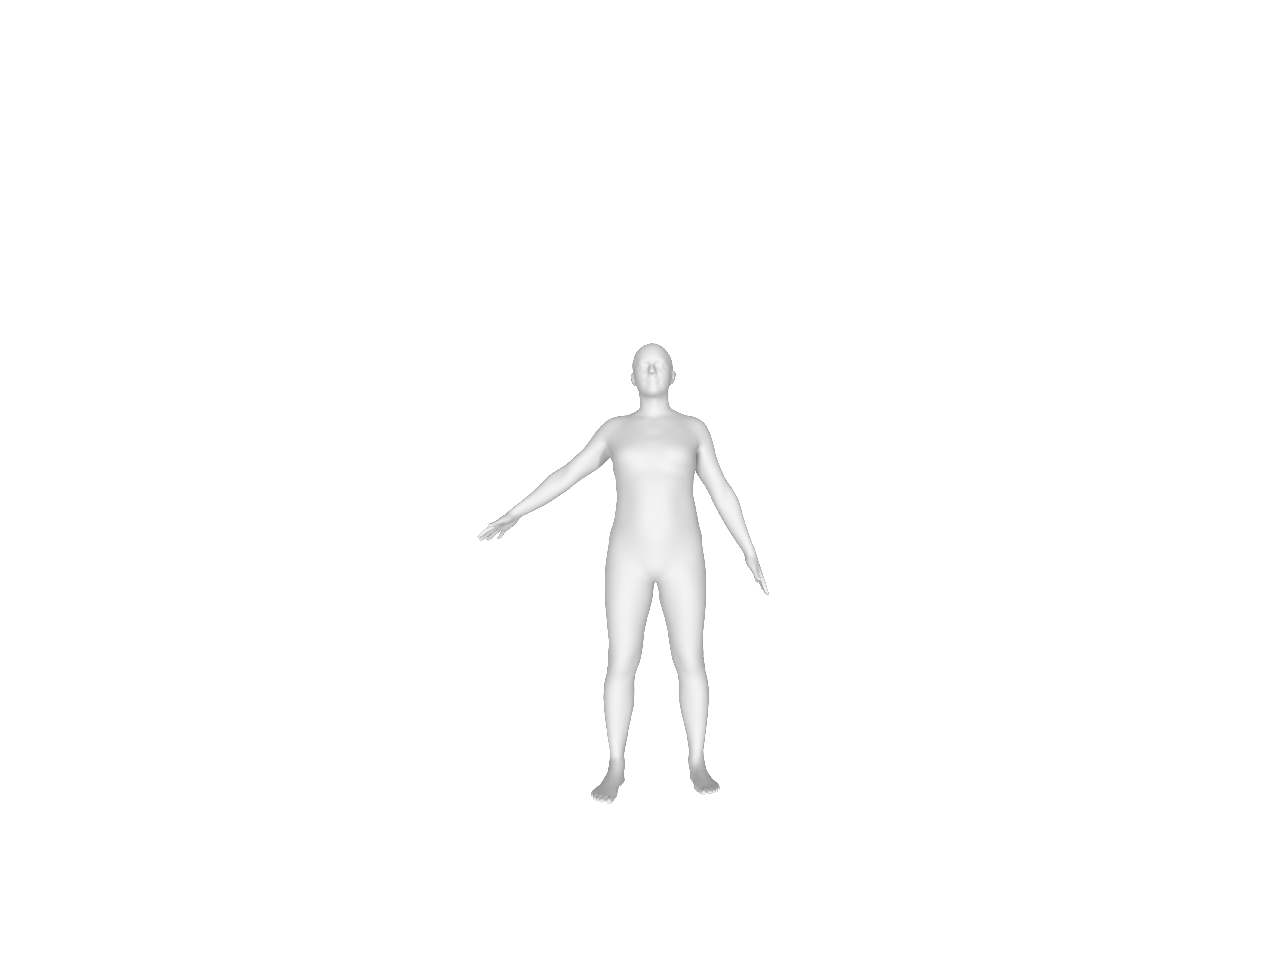

<IPython.core.display.Javascript object>


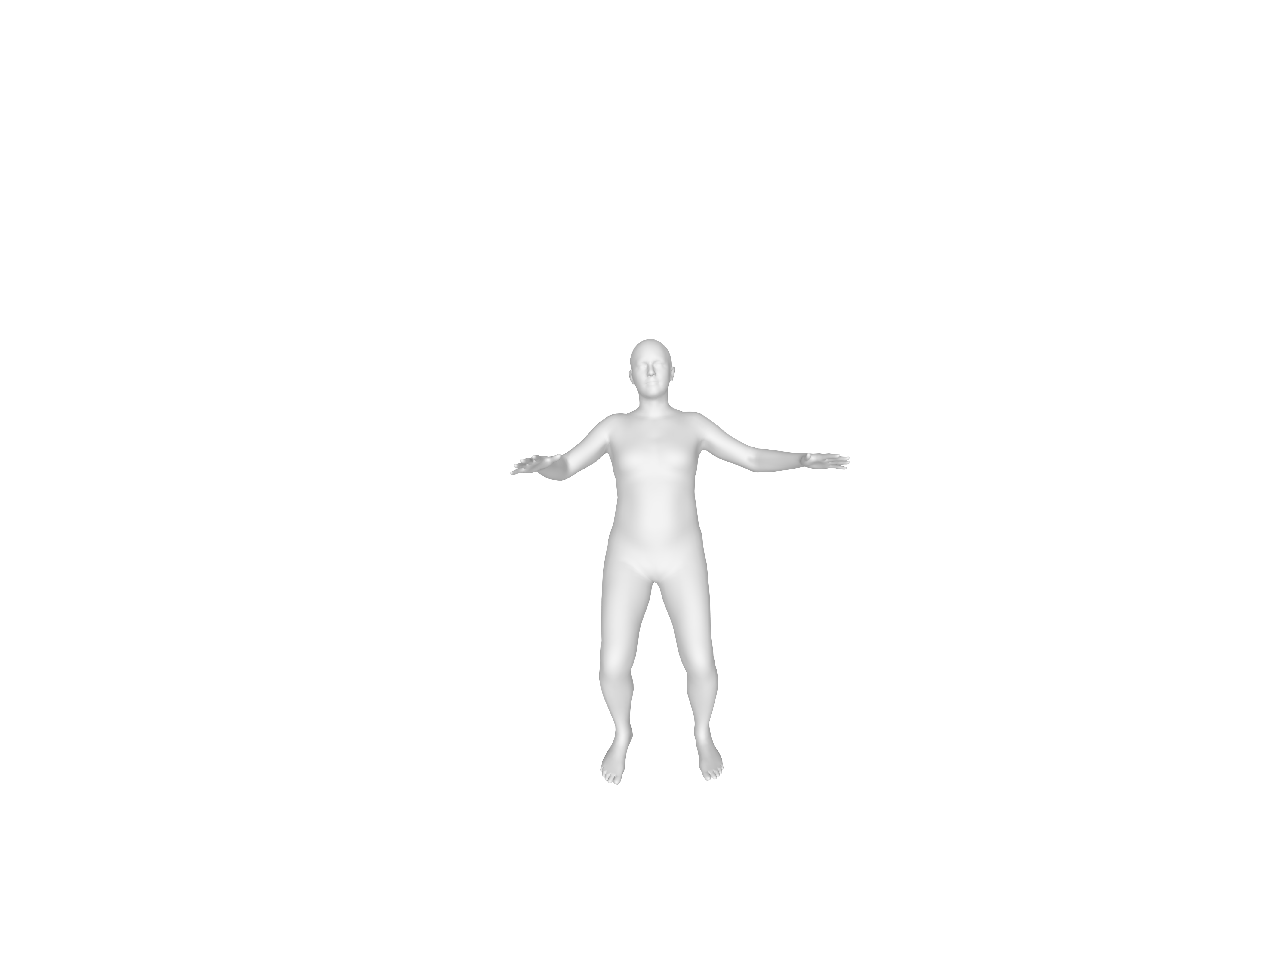

<IPython.core.display.Javascript object>


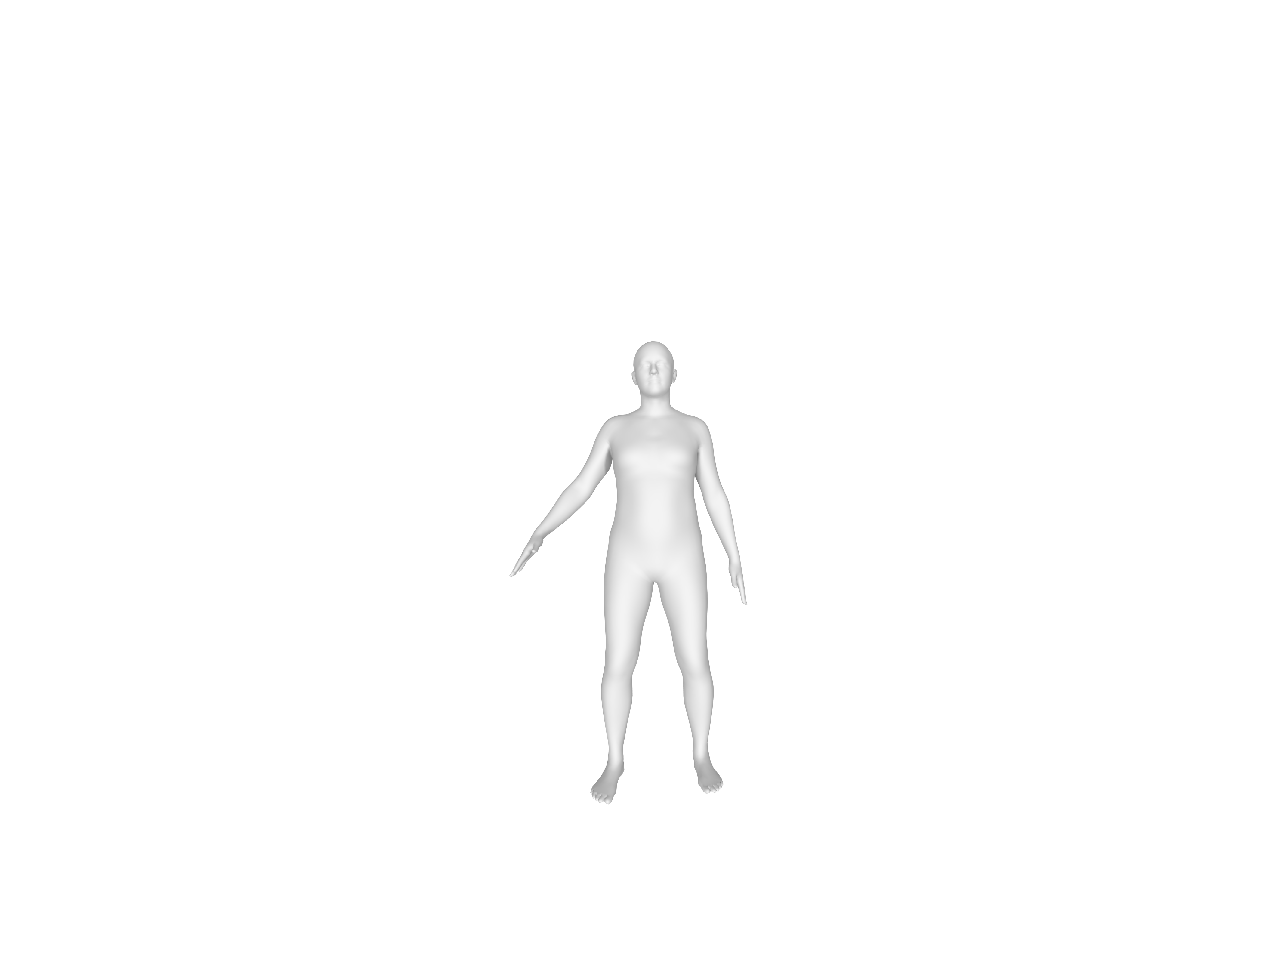

<IPython.core.display.Javascript object>


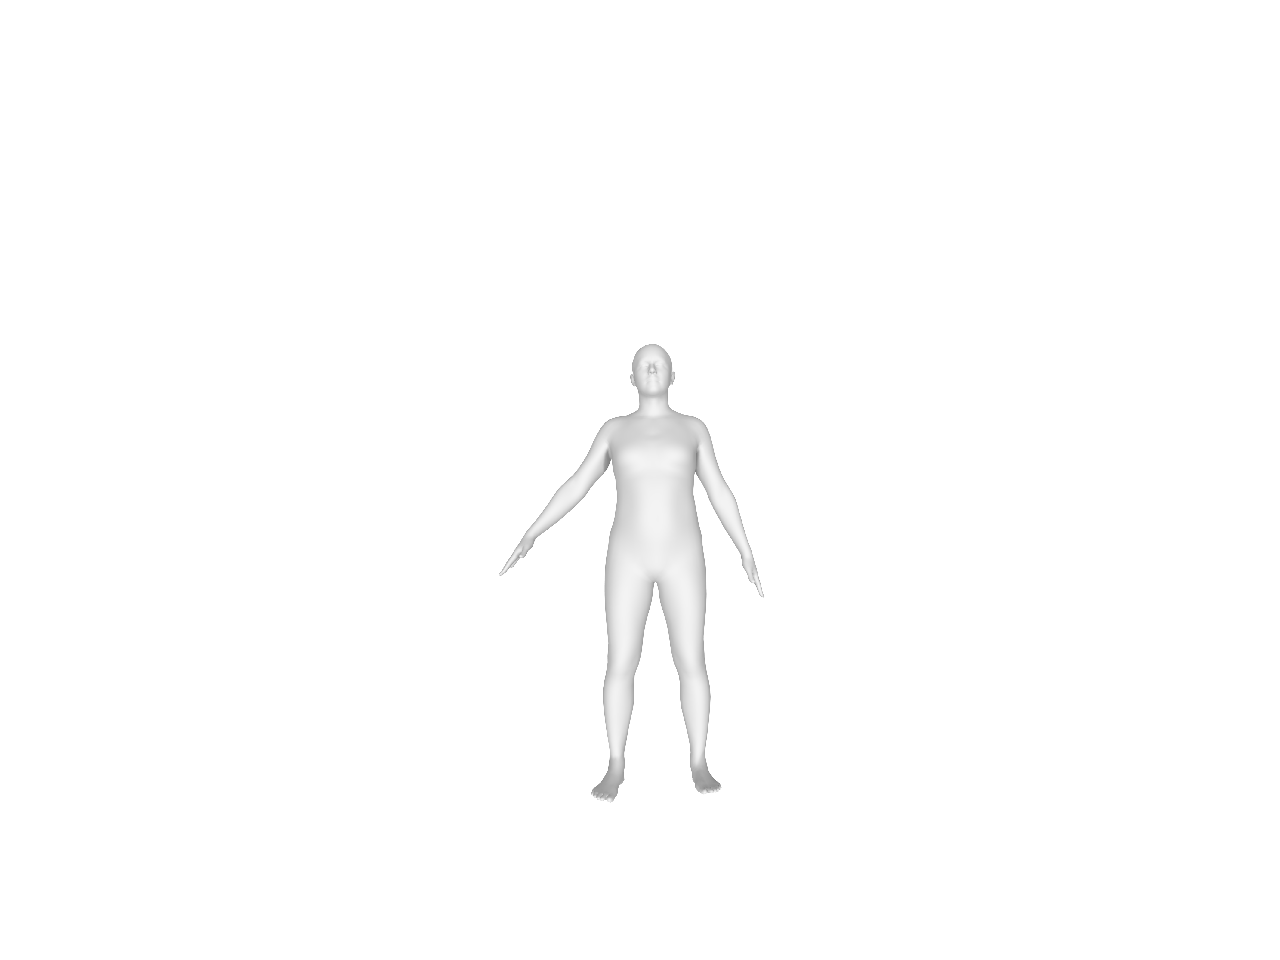

<IPython.core.display.Javascript object>


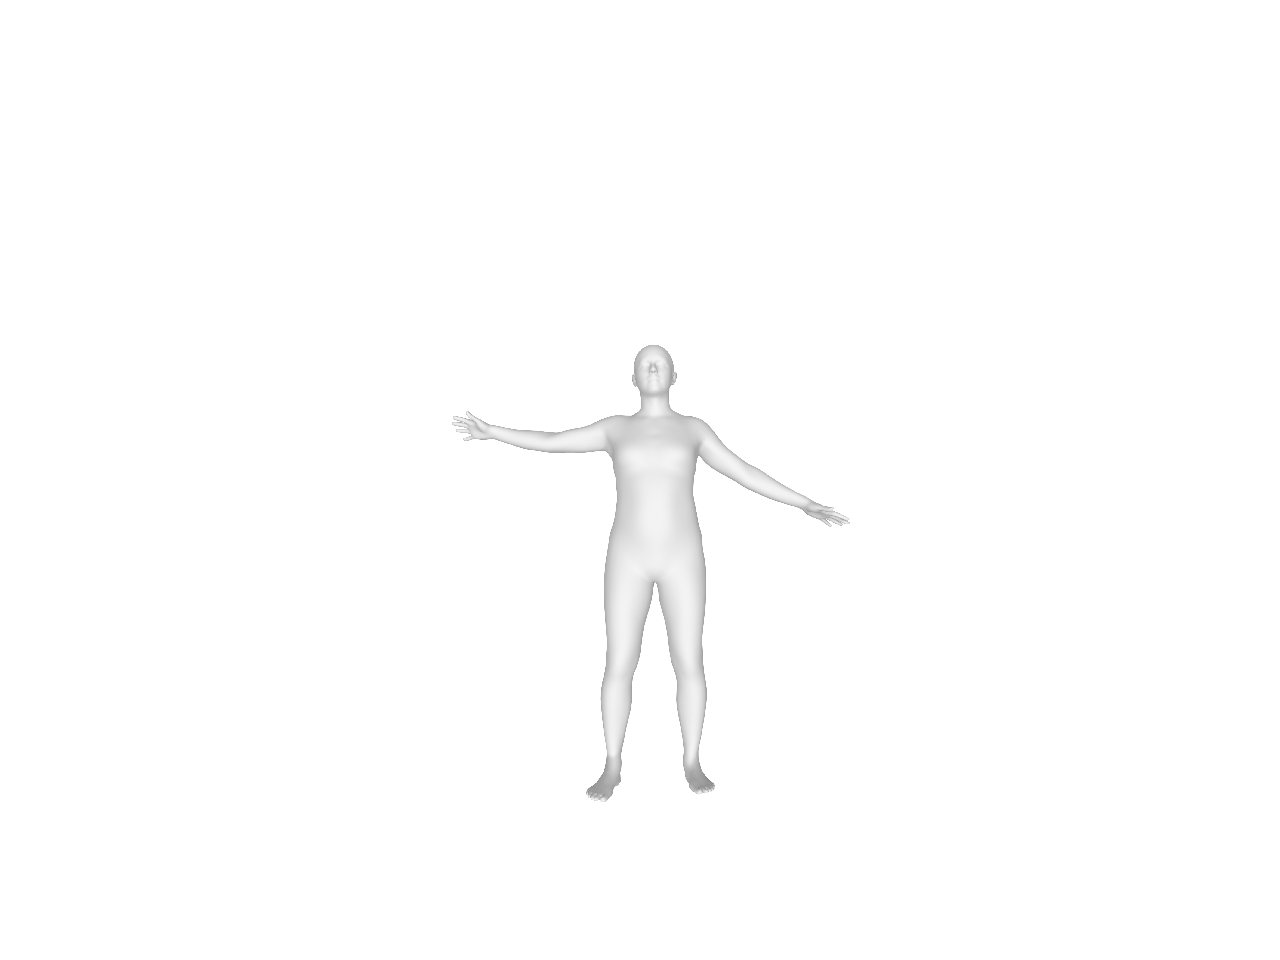

In [63]:
t = 19
for i in range(5):
    f = plt.figure()
    plt.axis('off')
    ax = f.gca()
    im = get_img_mesh(p_q.component_distribution.mean[:, t, 1:, i])
    alpha = np.zeros((3200, 3200, 1)).astype(int)
    alpha[:, :, 0] = (im.mean(axis=-1) != 255).astype(int) * 255
    im = np.concatenate([im, alpha], axis=-1)
    plt.imshow(im, alpha=1.0, interpolation='none')
    plt.savefig(f'./mode_{i}_front.png', bbox_inches='tight', dpi=500)

<IPython.core.display.Javascript object>


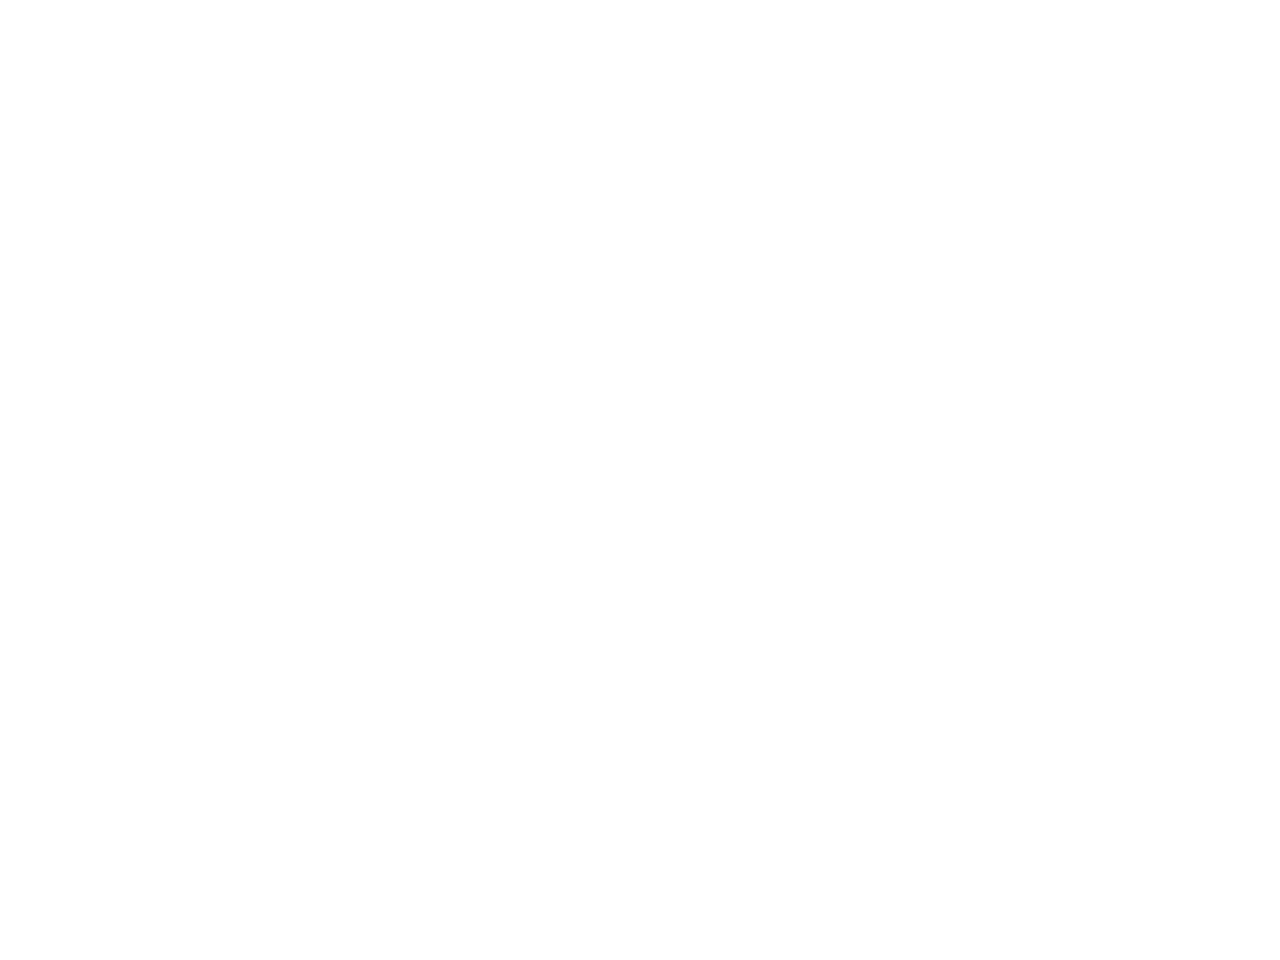

AttributeError: 'QuaternionMultivariateNormalTimeSeries' object has no attribute 'M'

In [58]:
t = 20
f = plt.figure()
plt.axis('off')
ax = f.gca()
for i in range(10):
    im = get_img_mesh90(p_q.component_distribution.M[:, t, :, i,  -1, :])
    alpha = np.zeros((3200, 3200, 1)).astype(int)
    alpha[:, :, 0] = (im.mean(axis=-1) != 255).astype(int) * 255
    im = np.concatenate([im, alpha], axis=-1)
    plt.imshow(im, alpha=1.0, interpolation='none')
#plt.savefig('./modes_10_top.png', bbox_inches='tight', dpi=500)

In [265]:
x.shape

torch.Size([1, 40, 22, 4])

<IPython.core.display.Javascript object>


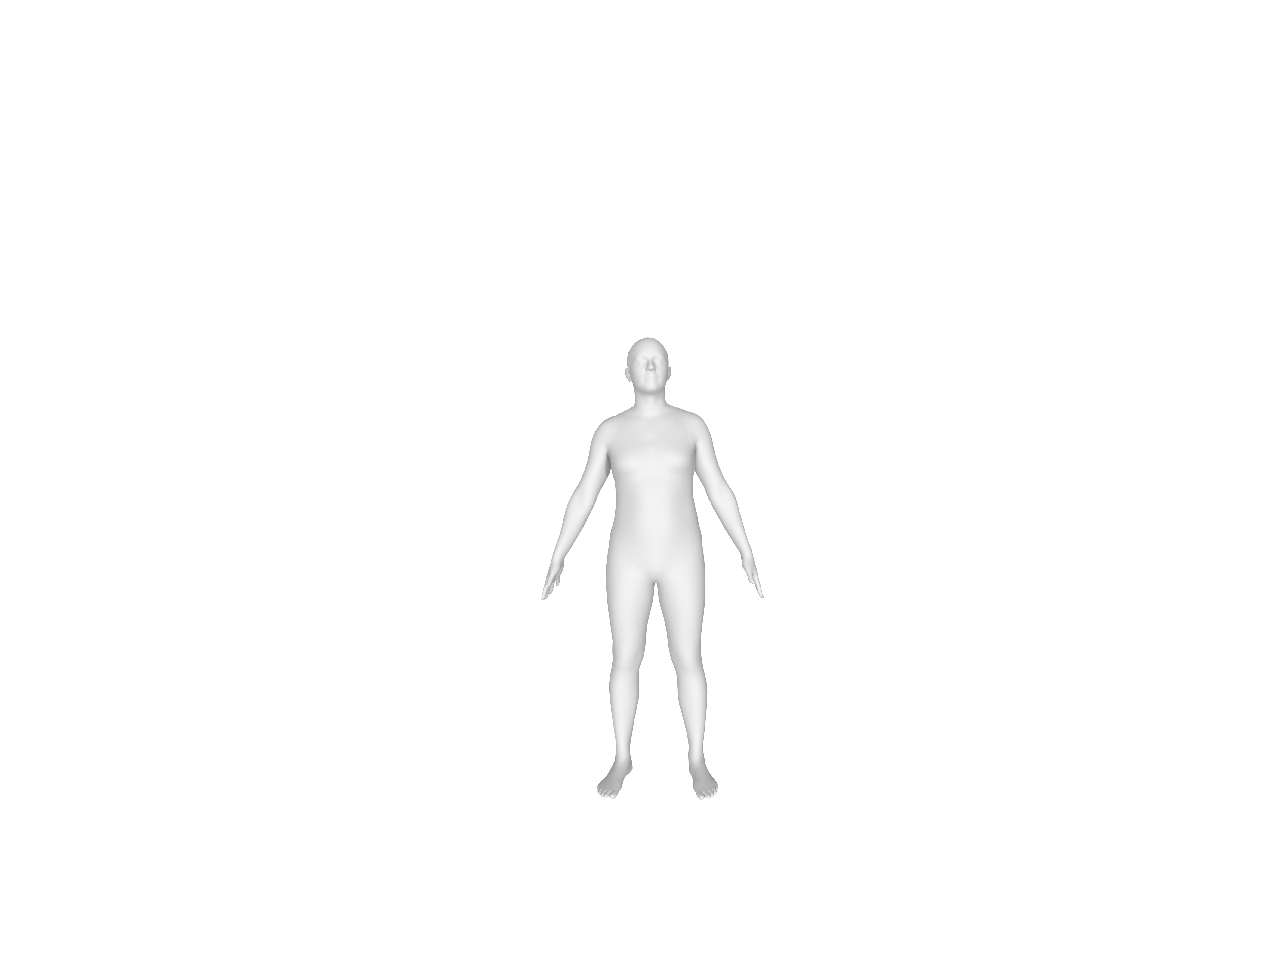

In [64]:
t = 19
f = plt.figure()
plt.axis('off')
ax = f.gca()

img = get_img_mesh(y[:, t, 1:])
plt.imshow(img, interpolation='none')
plt.savefig('./gt_front_1s.png', bbox_inches='tight', dpi=500)

<IPython.core.display.Javascript object>


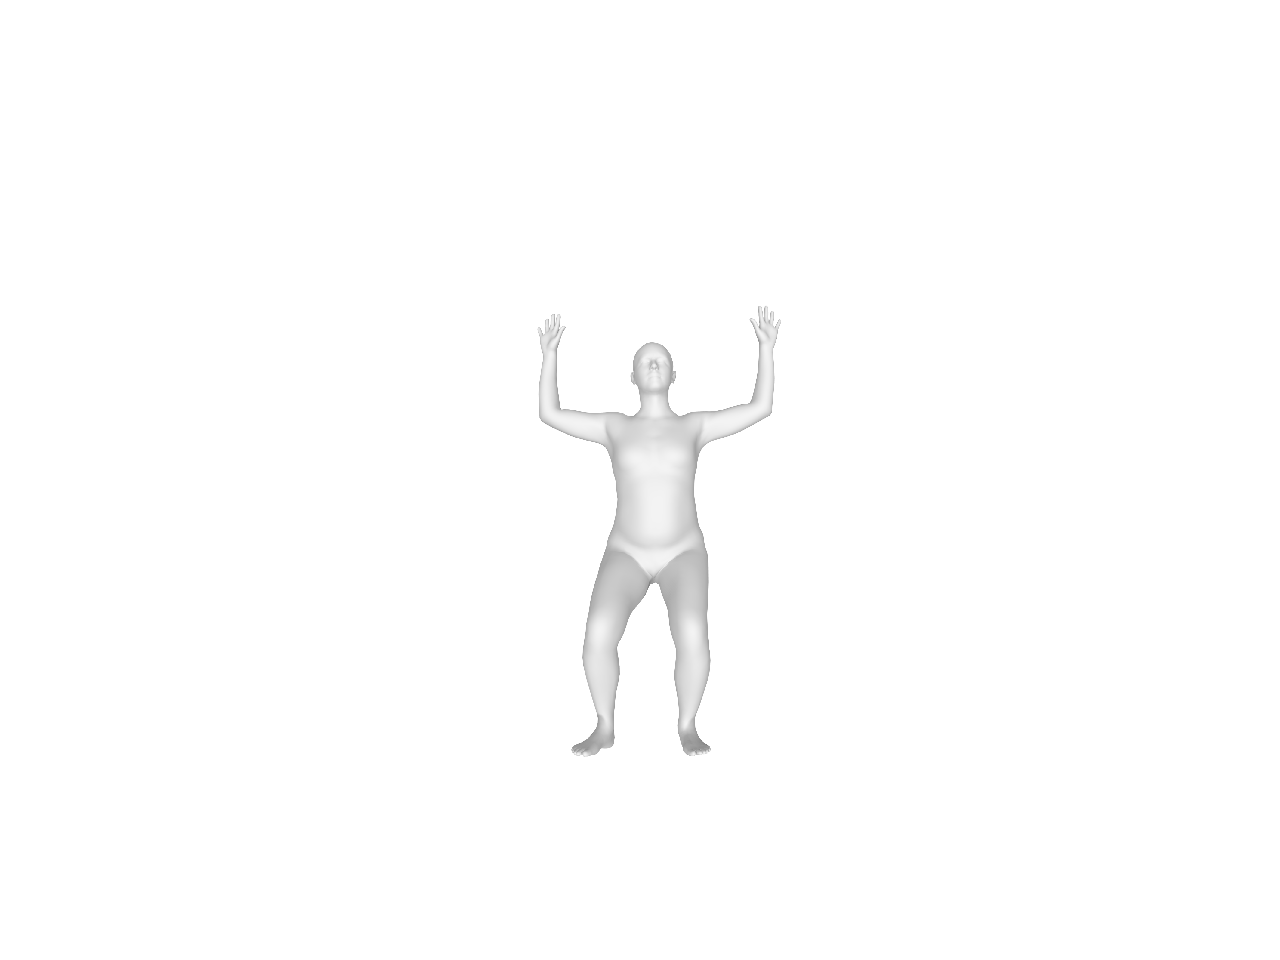

In [272]:
f = plt.figure()
plt.axis('off')
ax = f.gca()

img = get_img_mesh(x[:, -1, 1:])
plt.imshow(img, interpolation='none')
plt.savefig('./gt_t0.png', bbox_inches='tight', dpi=500)

<IPython.core.display.Javascript object>


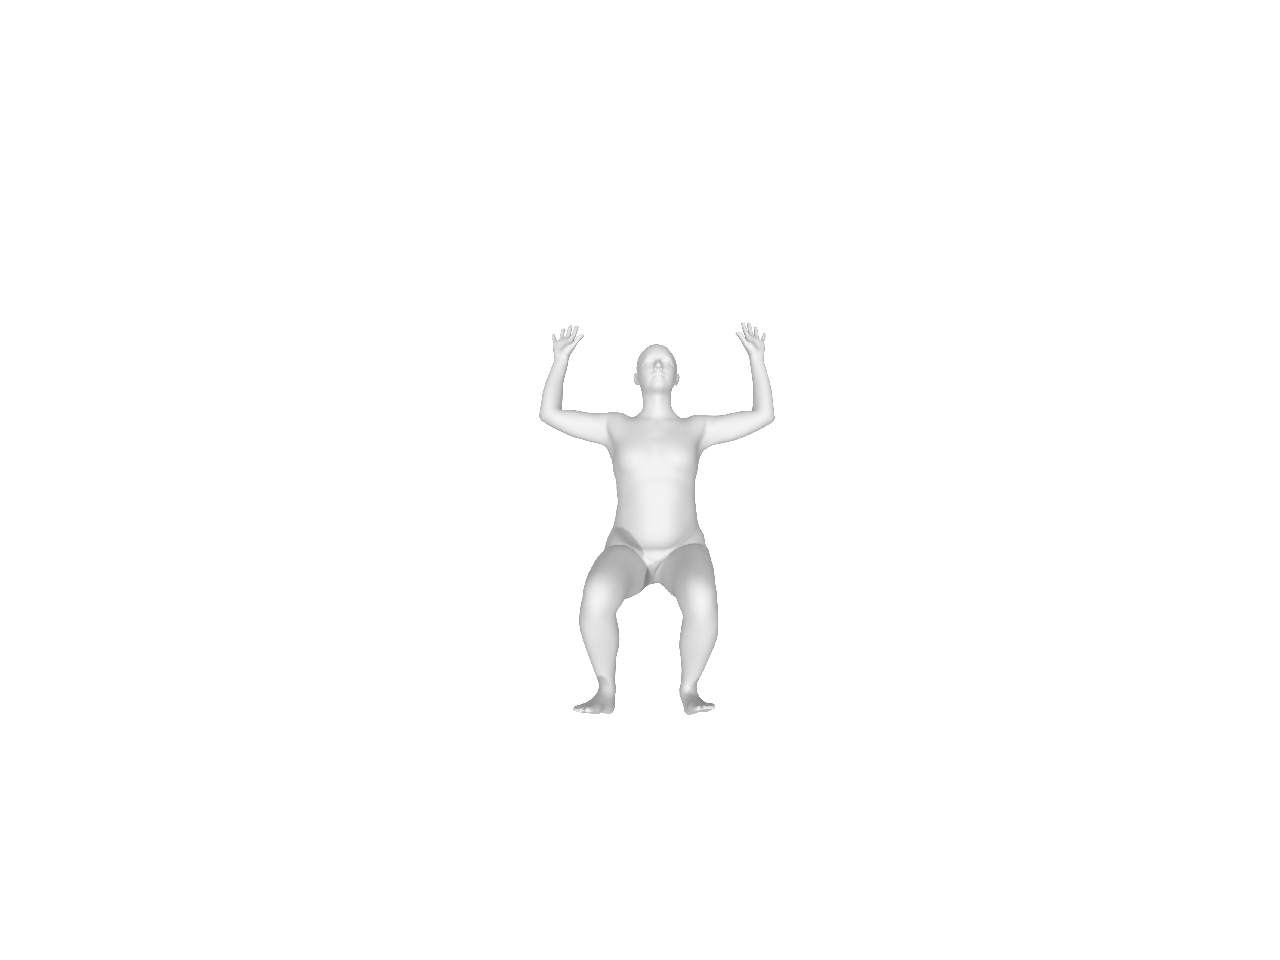

In [274]:
f = plt.figure()
plt.axis('off')
ax = f.gca()

img = get_img_mesh(x[:, -11, 1:])
plt.imshow(img, interpolation='none')
plt.savefig('./gt_tm10.png', bbox_inches='tight', dpi=500)

<IPython.core.display.Javascript object>


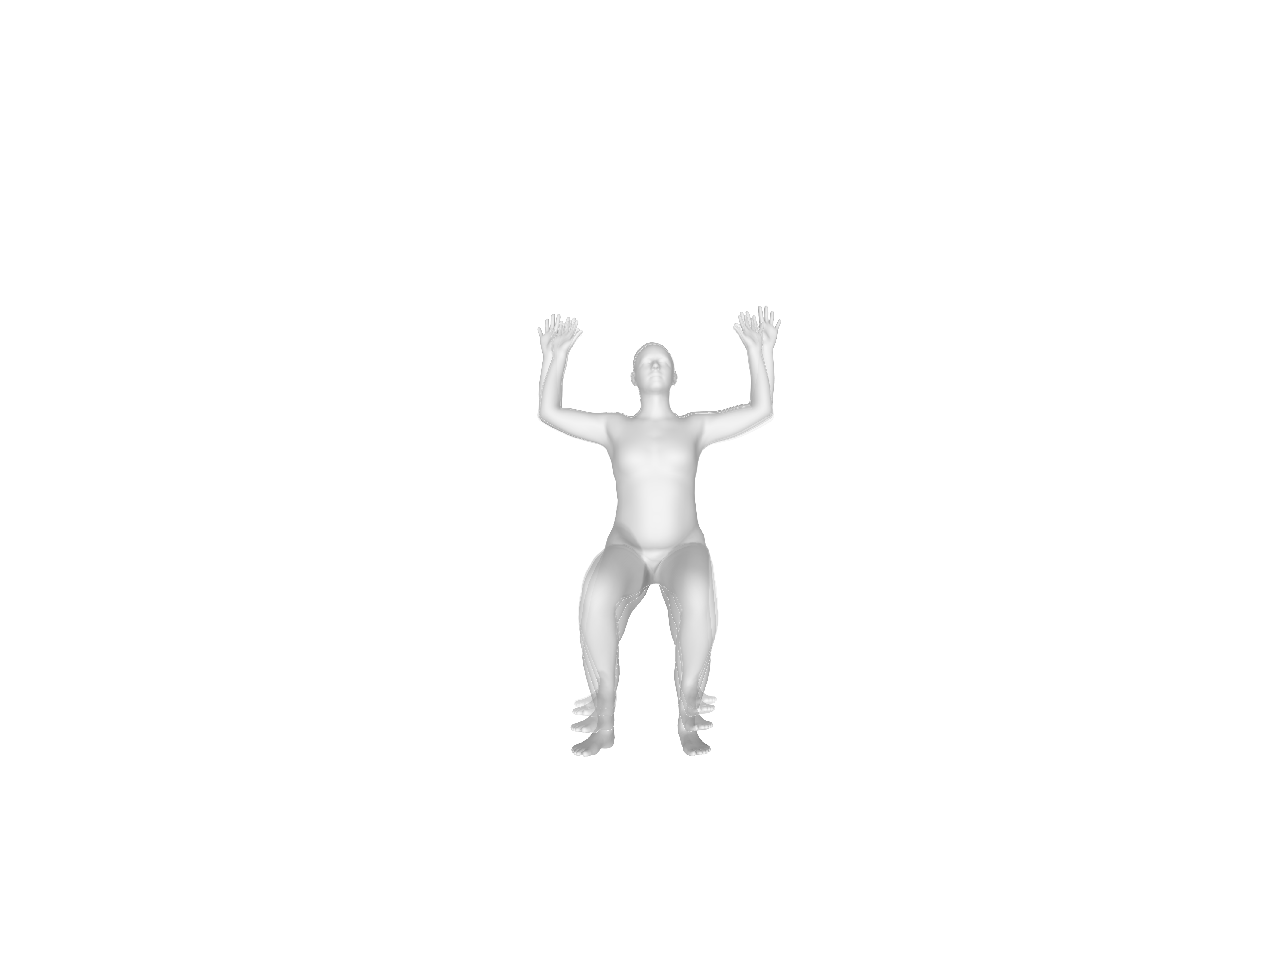

-1
1.0
-3
0.7777777777777778
-5
0.5555555555555556
-7
0.3333333333333333
-9
0.1111111111111111


In [271]:
f = plt.figure()
plt.axis('off')
ax = f.gca()
for i in range(1, 10, 2):
    i = -i
    print(i)
    im = get_img_mesh(x[:, i, 1:])
    alpha = np.zeros((3200, 3200, 1)).astype(int)
    alpha[:, :, 0] = (im.mean(axis=-1) != 255).astype(int) * 255
    im = np.concatenate([im, alpha], axis=-1)
    print(((10+i)/9))
    plt.imshow(im, alpha= ((10+i)/9), interpolation='none')
plt.savefig('./hist_front.png', bbox_inches='tight', dpi=500)

In [116]:
_, m_idx = p_q.mixture_distribution.probs[0, 0, 0, :].sort()

torch.return_types.sort(
values=tensor([0.0036, 0.0067, 0.0141, 0.0299, 0.0302, 0.0396, 0.1111, 0.1404, 0.2892,
        0.3353]),
indices=tensor([3, 4, 1, 0, 8, 5, 9, 6, 2, 7]))

In [124]:
im.shape

(3200, 1600, 3)

<IPython.core.display.Javascript object>


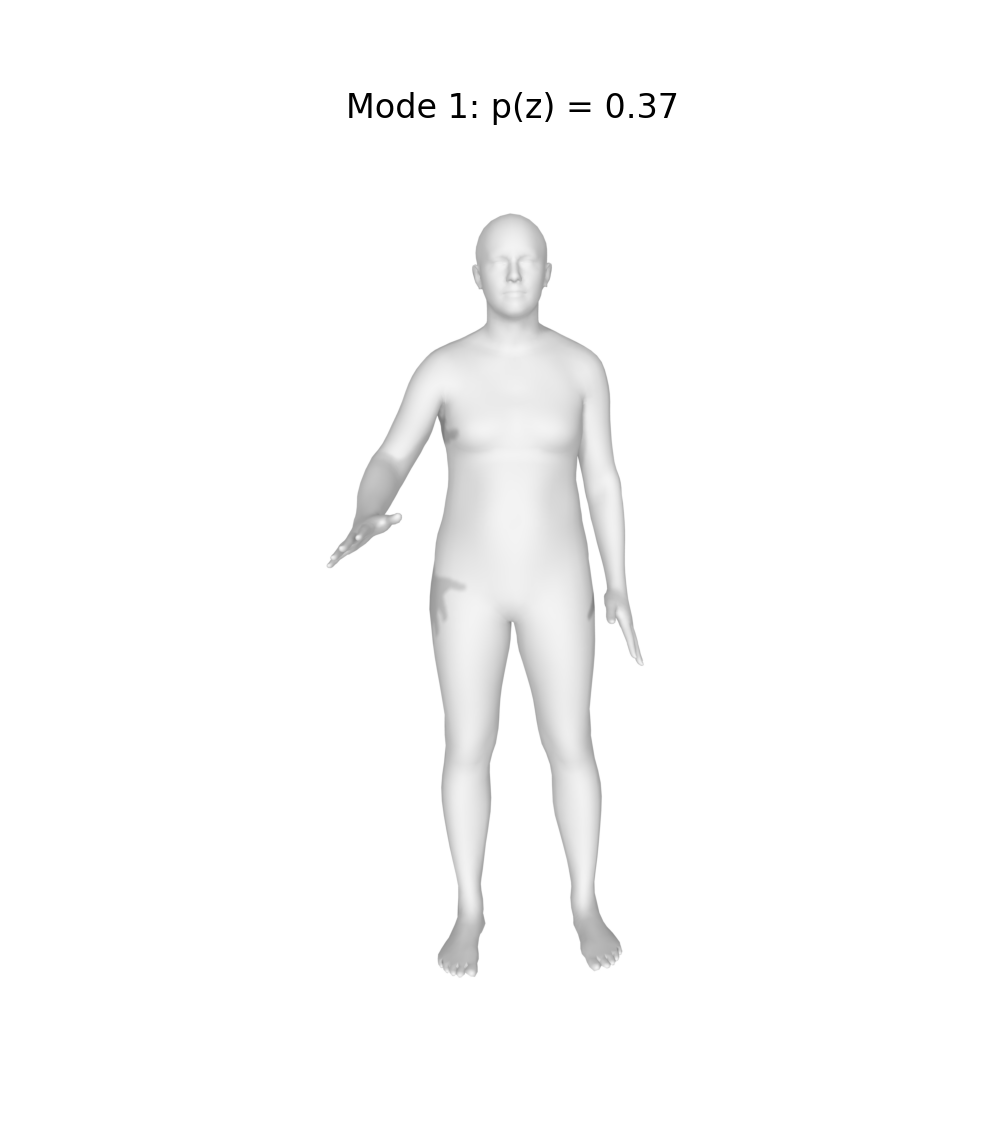

<IPython.core.display.Javascript object>


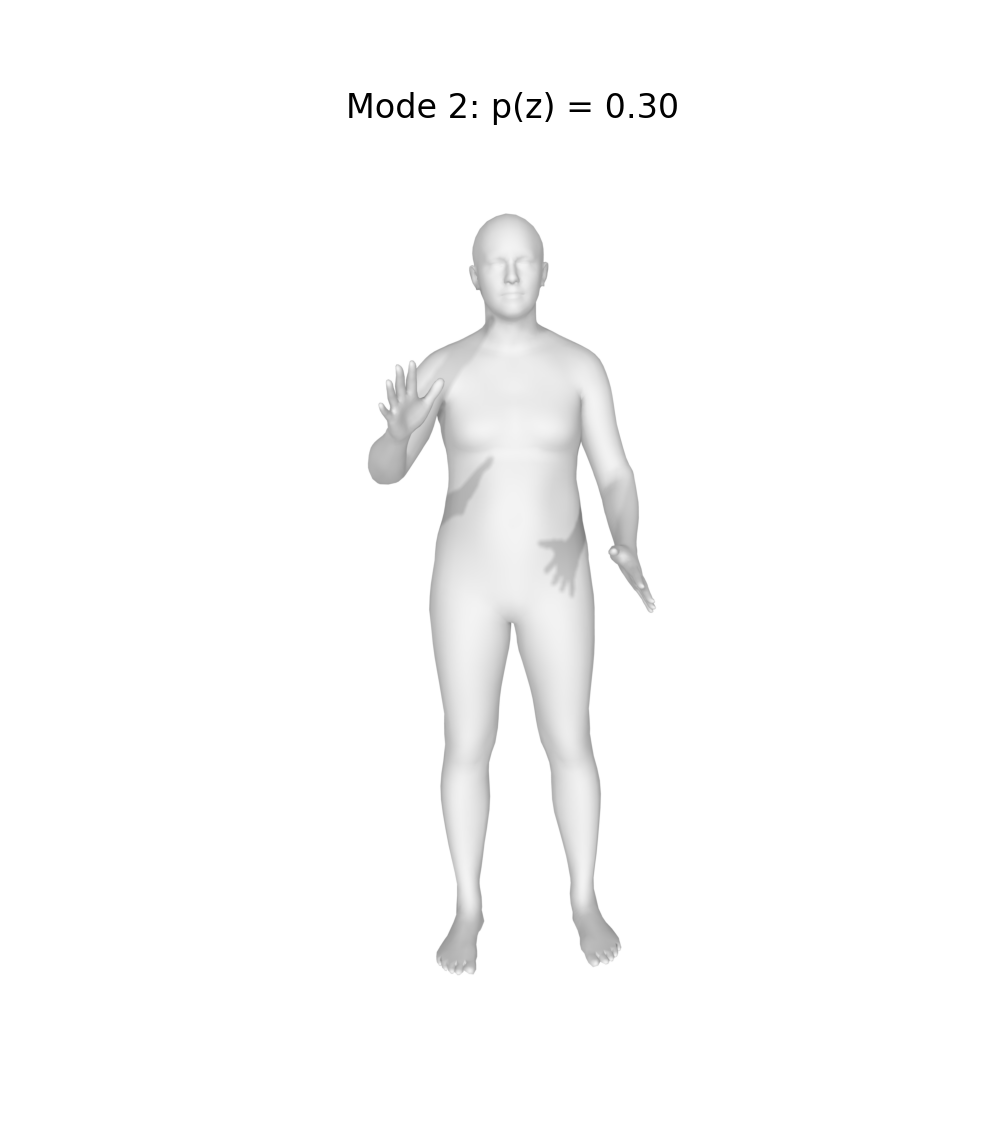

<IPython.core.display.Javascript object>


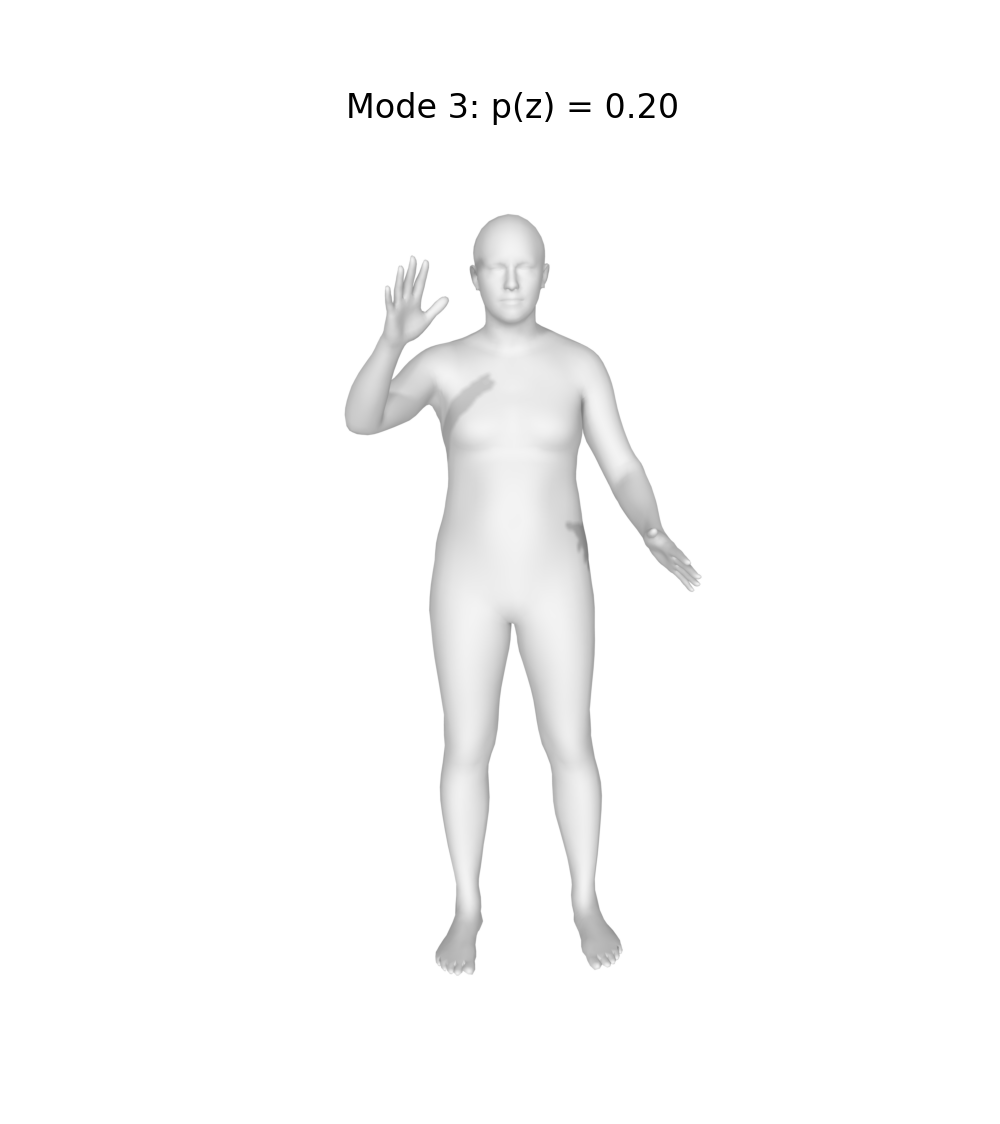

<IPython.core.display.Javascript object>


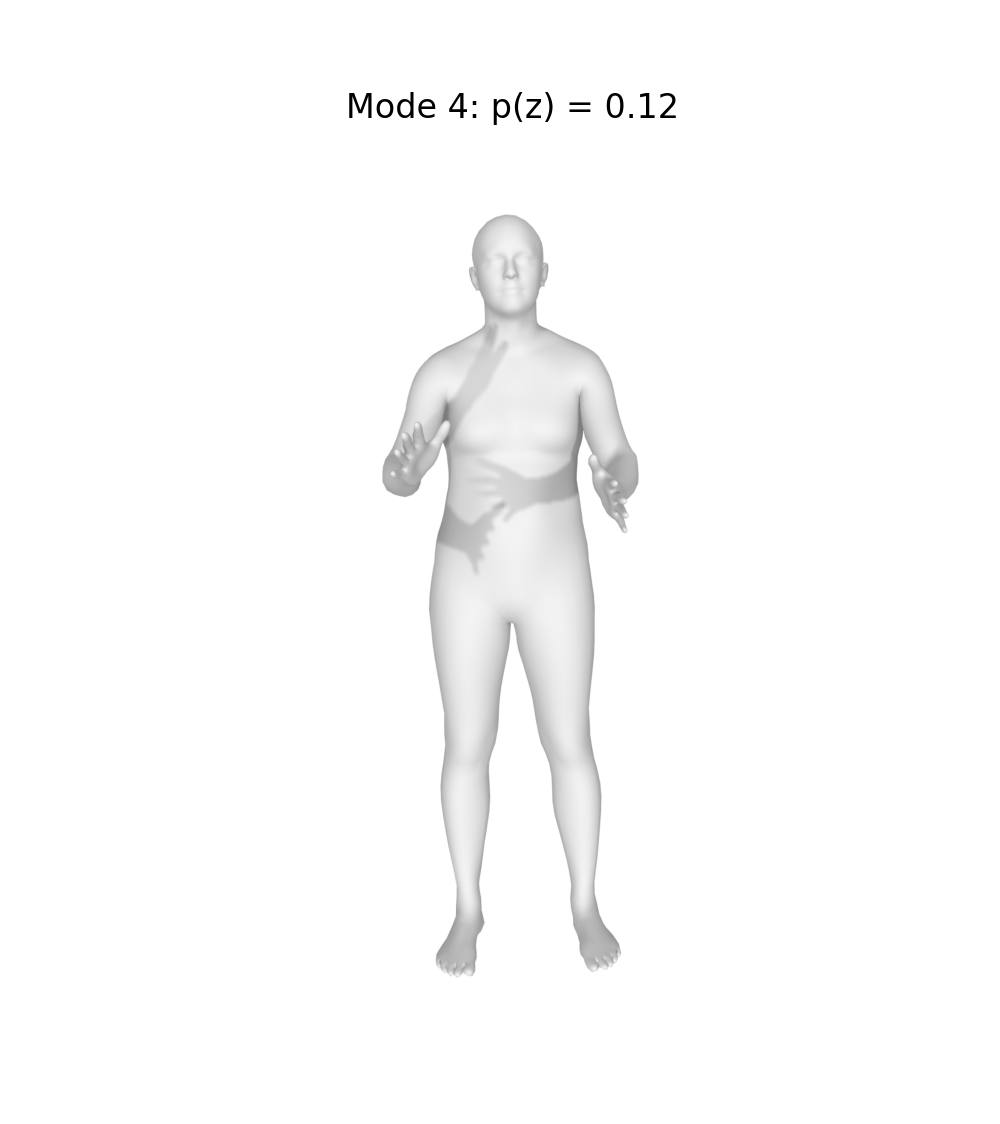

<IPython.core.display.Javascript object>


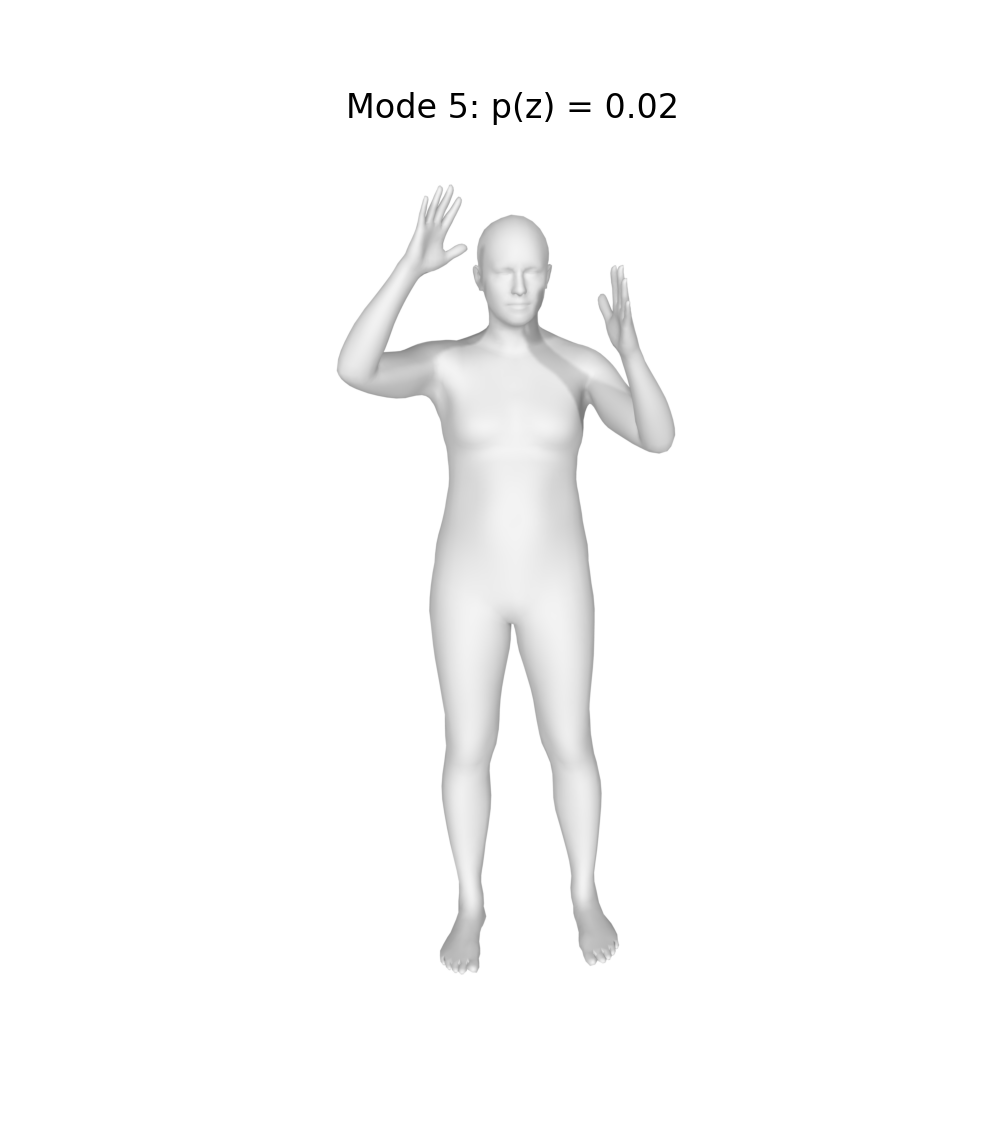

In [41]:
import matplotlib.cm as cm
import matplotlib.animation as animation
_, m_idx = p_q.mixture_distribution.probs[0, 0, 0, :].sort(descending=True)
for m in range(5):
    img = [] # some array of images
    for t in range(20):
        im = get_img_mesh(p_q.component_distribution.mean[:, t, 1:, m_idx[m]])
        img.append(im[750:-180])
    frames = [] # for storing the generated images
    fig = plt.figure(figsize=(5, 5.625))
    plt.axis('off')
    plt.title(f"Mode {m + 1}: p(z) = {float(p_q.mixture_distribution.probs[0, 0, 0, m_idx[m]]):.2f}")
    for i in range(20):
        frames.append([plt.imshow(img[i], animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                    repeat_delay=1000)
    ani.save(f"figures/sequence_2_mode_{m}.mp4", dpi=300, bitrate=100000)
    plt.show()

<IPython.core.display.Javascript object>


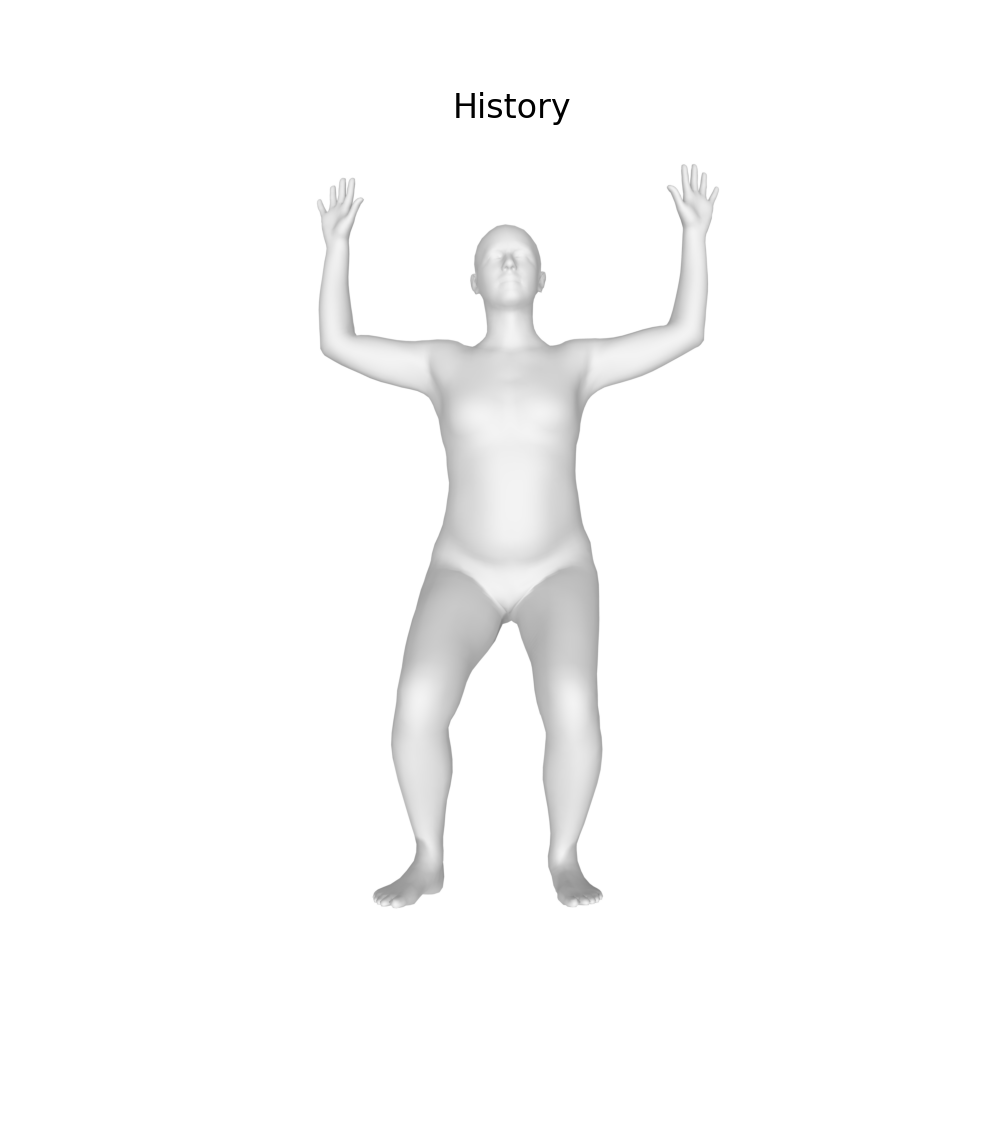

In [176]:
import matplotlib.cm as cm
import matplotlib.animation as animation
img = [] # some array of images
for t in range(40):
    im = get_img_mesh(x[:, t, 1:])
    img.append(im[750:-180])
frames = [] # for storing the generated images
fig = plt.figure(figsize=(5, 5.625))
plt.axis('off')
plt.title(f"History")
for i in range(40):
    frames.append([plt.imshow(img[i], animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save(f"figures/sequence_1_history.mp4", dpi=300, bitrate=100000)
#plt.show()

<IPython.core.display.Javascript object>


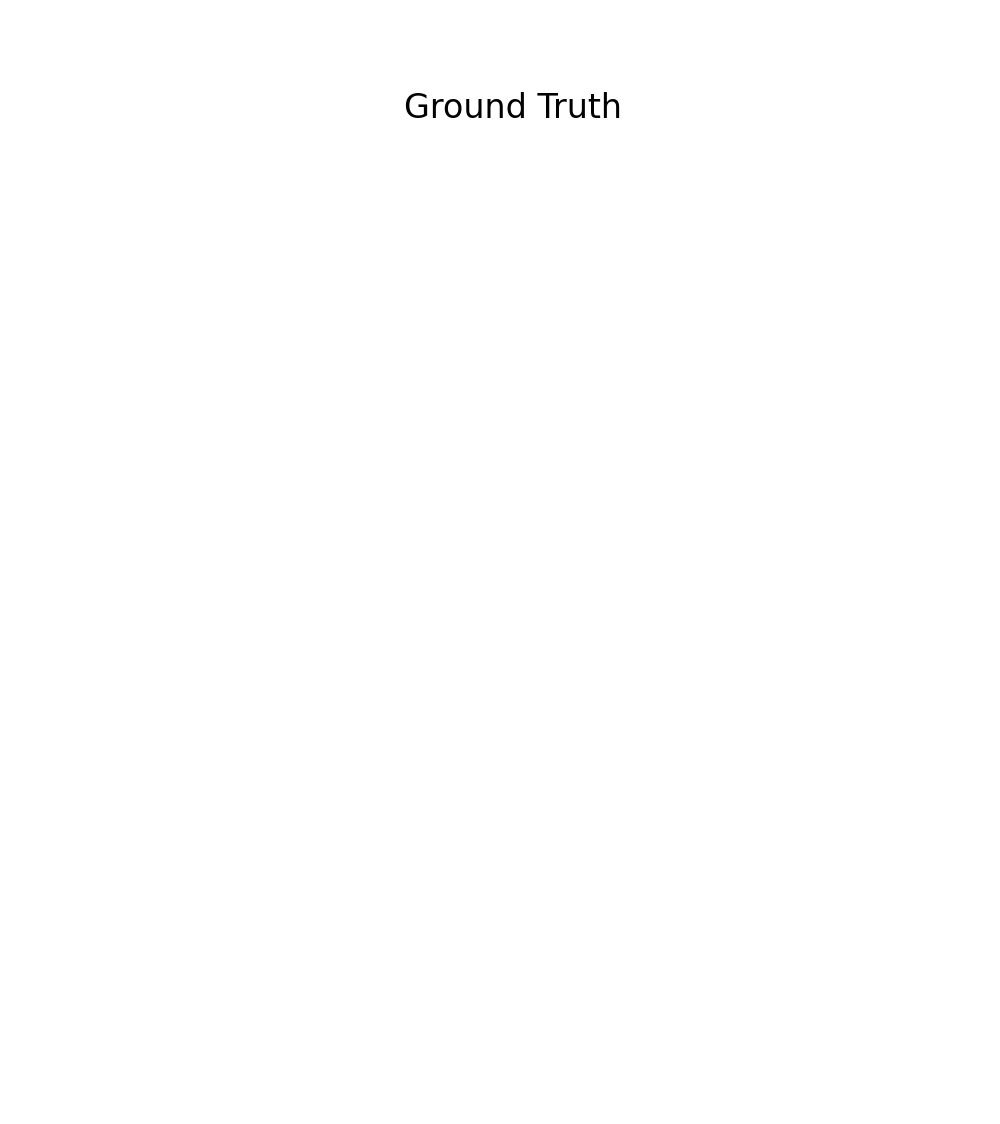

In [175]:
import matplotlib.cm as cm
import matplotlib.animation as animation
img = [] # some array of images
for t in range(20):
    im = get_img_mesh(y[:, t, 1:])
    img.append(im[750:-180])
frames = [] # for storing the generated images
fig = plt.figure(figsize=(5, 5.625))
plt.axis('off')
plt.title(f"Ground Truth")
for i in range(20):
    frames.append([plt.imshow(img[i], animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save(f"figures/sequence_1_gt.mp4", dpi=300, bitrate=100000)
#plt.show()